**Install Dependencies**

In [1]:
# %%capture
# !pip install -U fastai diffusers transformers jupyter huggingface-hub;

**Check diffusers version**

In [2]:
import diffusers
diffusers.__version__

'0.7.1'

**Import dependencies**

In [3]:
from pathlib import Path
import hashlib
import json

import logging
logging.disable(logging.WARNING)

from PIL import Image
import numpy as np
import torch

import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler, EulerDiscreteScheduler

from tqdm.auto import tqdm

**Log into Hugging Face Hub**

1. Generate a user access token: [Access Tokens](https://huggingface.co/settings/tokens)
2. Paste your token when prompted after running the code cell below.

In [4]:
from huggingface_hub import notebook_login
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

**Verify cached token**

In [5]:
!ls ~/.huggingface

token


**Accept Model License**

The Stable Diffusion checkpoints are available under the [CreativeML OpenRail-M license](https://huggingface.co/spaces/CompVis/stable-diffusion-license). The license claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. Open the Model Card pages below and accept the license agreement to download the pretrained models.. 


If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work. You have two options to provide your access token:

* [**Stable Diffusion v1-4 Model Card**](https://huggingface.co/CompVis/stable-diffusion-v1-4)
* [**Stable Diffusion v1-5 Model Card**](https://huggingface.co/runwayml/stable-diffusion-v1-5)

**Select a model**

In [6]:
# model_name = "CompVis/stable-diffusion-v1-4"
model_name = "runwayml/stable-diffusion-v1-5"

**Load autoencoder**

In [7]:
vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae", torch_dtype=torch.float16).to("cuda")

# vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16).to("cuda")
# vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")

**Load unet**

In [8]:
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet", torch_dtype=torch.float16).to("cuda")

**Select a CLIP model**

In [9]:
clip_name = "openai/clip-vit-large-patch14"

**Load tokenizer**

In [10]:
tokenizer = CLIPTokenizer.from_pretrained(clip_name, torch_dtype=torch.float16)

**Load text encoder**

In [11]:
text_encoder = CLIPTextModel.from_pretrained(clip_name, torch_dtype=torch.float16).to("cuda")

**Define noise scheduler**

In [12]:
# scheduler = LMSDiscreteScheduler(beta_start=0.00085, 
#                                  beta_end=0.012, 
#                                  beta_schedule="scaled_linear", 
#                                  num_train_timesteps=1000)

In [13]:
scheduler = EulerDiscreteScheduler.from_config("runwayml/stable-diffusion-v1-5", subfolder="scheduler")

**Define method to tokenizer and encode text**

In [14]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

**Define method to convert output tensor to image**

In [15]:
def tensor_to_img(tensor):
    image = (tensor/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

**Define method to save image with unique file name**

In [16]:
def save_img(image, save_dir, fmt='PNG'):
    img_hash = hashlib.sha256(np.array(image)).hexdigest()[:24]
    image.save(f"{save_dir}/{img_hash}.{fmt.lower()}", format=fmt)
    return img_hash

**Define method to pipeline config used to generate an image**

In [17]:
def save_pipe_config(img_name, pipe_config, save_dir):
    with open(f"{save_dir}/{img_name}.json", "w") as write_file:
        json.dump(pipe_config, write_file)

**Define method to encode image as latents**

In [18]:
from torchvision import transforms as tfms

In [19]:
def pil_to_latent(image):
    # Single image -> single latent in a batch
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(image).unsqueeze(0).to('cuda').half()*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

In [20]:
from collections import namedtuple
from torchvision import models


class Vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg16, self).__init__()
        vgg_pretrained_features = models.vgg16(weights=models.vgg.VGG16_Weights.IMAGENET1K_V1).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out

In [21]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

In [22]:
vgg = Vgg16(requires_grad=False).to('cuda')

In [23]:
from torchvision import transforms

In [24]:
style_transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Lambda(lambda x: x.mul(255))
])

**Open Style Image**

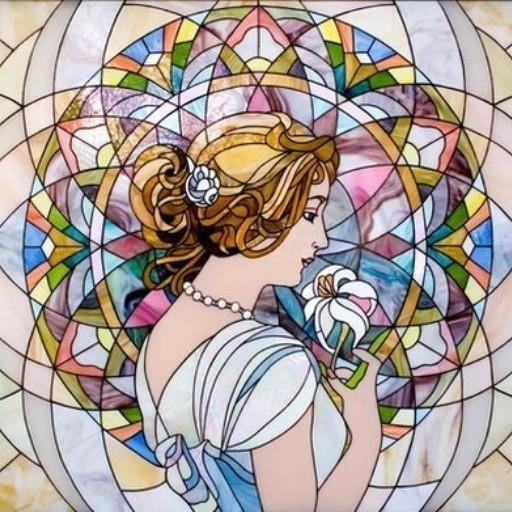

In [25]:
style_path = Path("./style_images/mosaic.jpg")
style_image = Image.open(style_path)
style_image

In [26]:
style_tensor = style_transform(style_image)

In [27]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
mean_tensor = torch.Tensor(mean).view(1,1,-1).permute(2, 0, 1).to('cuda')
std_tensor = torch.Tensor(std).view(1,1,-1).permute(2, 0, 1).to('cuda')

In [28]:
norm_style_tensor = (style_tensor.to('cuda') - mean_tensor) / std_tensor
norm_style_tensor = norm_style_tensor.unsqueeze(dim=0)
norm_style_tensor.shape

torch.Size([1, 3, 512, 512])

In [29]:
features_style = vgg(norm_style_tensor)

In [30]:
gram_style = [gram_matrix(y) for y in features_style]

**Define method to perform text2img generation**

In [31]:
def generate_text2img_vgg_loss(prompt, style_image, loss_scale=10, negative_prompt="", 
                               height=512, width=512, g=0.15, steps=70, generator=None):

    # Encode text prompt
    text = text_enc(prompt)
    # Encode negative prompt
    uncond = text_enc(negative_prompt, text.shape[1])
    # Concatenate encoded prompts
    emb = torch.cat([uncond, text])
    
    # Get style image latents
#     style_latents = pil_to_latent(style_image)
    # Define loss function
    mse_loss = torch.nn.MSELoss()
    
    # Initialize noisy latents
    latents_shape = (1, unet.in_channels, height//8, width//8)
    latents = torch.randn(latents_shape, generator=generator, device='cuda', dtype=emb.dtype)
    
    # Set number of time steps for diffusion process
    scheduler.set_timesteps(steps)
    # Scale noisy latents
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        # Scale latents
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        # Get model output
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        
        # Rescale guidance
        # https://forums.fast.ai/t/lesson-10-official-topic/101171/101
        pred_nonscaled= u + g*(t-u)/torch.norm(t-u)*torch.norm(u)
        pred = pred_nonscaled * torch.norm(u)/torch.norm(pred_nonscaled)
        
        if (i >= 15):
                
            #### ADDITIONAL GUIDANCE ###
            # Requires grad on the latents
            latents = latents.detach().requires_grad_()

            # Get the predicted x0:
            latents_x0 = scheduler.step(pred, ts, latents).pred_original_sample

            # Decode to image space
            denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5
            denoised_images = denoised_images.clamp(0,1)

            norm_image_tensor = (denoised_images.squeeze() - mean_tensor) / std_tensor
            norm_image_tensor = norm_image_tensor.unsqueeze(dim=0)
            features_image = vgg(norm_image_tensor)
            torch.cuda.empty_cache()

            # Calculate loss
            loss = 0.
            for ft_y, gm_s in zip(features_image, gram_style):
                gm_y = gram_matrix(ft_y)
                loss += mse_loss(gm_y, gm_s[:1, :, :])
            loss *= loss_scale

            # Print the loss value
            if i%10==0: print(i, 'loss:', loss.item())

            # Get gradient
            cond_grad = torch.autograd.grad(loss, latents)[0]

            # Modify the latents based on this gradient
            latents = latents.detach() - cond_grad * scheduler.sigmas[i].to('cuda')**2
            ####
        
        # Update latents
        latents = scheduler.step(pred, ts, latents).prev_sample
        
        # Releases all unoccupied cached memory
        torch.cuda.empty_cache()
    
    # Decode output tensor
    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

**Define text prompt**

In [32]:
prompt = "A campfire (oil on canvas)"
prompt

'A campfire (oil on canvas)'

**Define negative prompt**

In [33]:
negative_prompt = "lowres, bad, error, blurry, compressed, incomplete"
negative_prompt

'lowres, bad, error, blurry, compressed, incomplete'

**Initialize random number generator for consistent images**

In [50]:
generator = torch.Generator(device='cuda')
generator.manual_seed(100);
# generator.manual_seed(789890158);
# generator.manual_seed(1);

**Define pipe config**

In [51]:
pipe_config = {}
pipe_config['model'] = model_name
pipe_config['prompt'] = prompt
pipe_config['style_img'] = str(style_path)
pipe_config['loss_scale'] = 3e5
pipe_config['negative_prompt'] = negative_prompt
pipe_config['height'] = 512
pipe_config['width'] = 512
pipe_config['steps'] = 80
pipe_config['guidance'] = 0.15
pipe_config['init_seed'] = generator.initial_seed()
pipe_config['generator_state'] = [int(i) for i in generator.get_state()]
pd.DataFrame.from_dict(pipe_config, orient='index')

,0
model,runwayml/stable-diffusion-v1-5
prompt,A campfire (oil on canvas)
style_img,style_images/mosaic.jpg
loss_scale,300000.0
negative_prompt,"lowres, bad, error, blurry, compressed, incomplete"
height,512
width,512
steps,80
guidance,0.15
init_seed,100


**Optional: Load a config file to recreate a specific image**

In [52]:
# config_path = Path("../pipe_configs/c85b8ebe3266dfdbcd25a4b4.json")

In [53]:
# with open(config_path) as f:
#     pipe_config = json.load(f)
#     generator_state = torch.tensor(pipe_config['generator_state'], dtype=torch.uint8)
#     generator.manual_seed(pipe_config['init_seed'])
#     generator.set_state(generator_state)
# pd.DataFrame.from_dict(pipe_config, orient='index')

**Define method that returns a stack of images**

In [54]:
def stack_imgs(imgs):
    w,h = imgs[0].size
    stack = Image.new('RGB', size=(w, len(imgs)*h))
    for i, img in enumerate(imgs): stack.paste(img, box=(0, i*h, w, (i+1)*h))
    return stack

**Define directory to store generated images**

In [55]:
output_dir = Path("./output_dir")
output_dir.mkdir(parents=True, exist_ok=True)
output_dir

PosixPath('output_dir')

**Specify number of images to generate**

In [56]:
num_images = 1

**Generate images**

  0%|          | 0/80 [00:00<?, ?it/s]

20 loss: 110.43797302246094
30 loss: 30.689685821533203
40 loss: 21.522676467895508
50 loss: 18.53990936279297
60 loss: 18.06329345703125
70 loss: 19.635526657104492


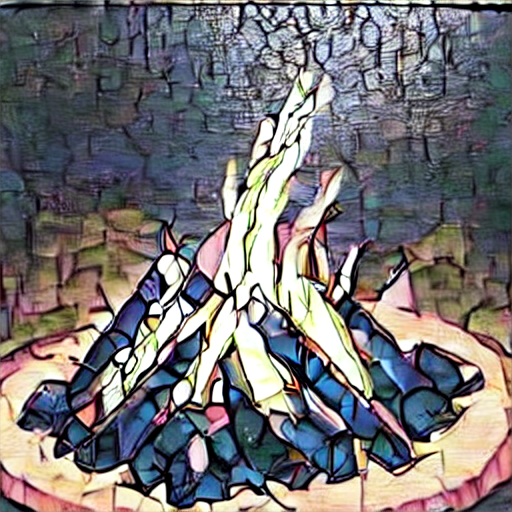

In [57]:
all_images = []
generator_states = []

for i in range(num_images):
    img_tensors = generate_text2img_vgg_loss(prompt=pipe_config['prompt'],
                                             style_image=style_image,
                                             loss_scale=pipe_config['loss_scale'],
                                             negative_prompt=pipe_config['negative_prompt'],
                                             height=pipe_config['height'],
                                             width=pipe_config['width'], 
                                             g=pipe_config['guidance'], 
                                             steps=pipe_config['steps'], 
                                             generator=generator)
    generator_states.append([int(i) for i in generator.get_state()])
    all_images.extend([tensor_to_img(t) for t in img_tensors])
    torch.cuda.empty_cache()
    
for i, image in enumerate(all_images):
    img_name = save_img(image, save_dir=output_dir)
    save_pipe_config(img_name=img_name, pipe_config=pipe_config, save_dir=output_dir)
    pipe_config['generator_state'] = generator_states[i]

stack_imgs(all_images)